# Solving Satisfiability Problems using Grover's Algorithm

In this section, we demonstrate how to solve satisfiability problems using the implementation of Grover's algorithm in Qiskit Aqua. 

## Contents

1. [Introduction](#introduction)

2. [3-Satisfiability Problem](#3satproblem)

3. [Qiskit Implementation](#implementation)

4. [Problems](#problems)

5. [References](#references)

## 1. Introduction <a id='introduction'></a>

Grover's algorithm for unstructured search was introduced in an [earlier section](../Chapter%204/grover_search.ipynb), with an example and implementation using Qiskit Terra. We saw that Grover search is a quantum algorithm that can be used search for correct solutions quadratically faster than its classical counterparts. Here, we are going to illustrate the use of Grover's algorithm to solve a particular combinatorial Boolean satisfiability problem. 

In computer science, the Boolean satisfiability problem is the problem of determining if there exists an interpretation that satisfies a given Boolean formula. In other words, it asks whether the variables of a given Boolean formula can be consistently replaced by the values TRUE or FALSE in such a way that the formula evaluates to TRUE. If this is the case, the formula is called satisfiable. On the other hand, if no such assignment exists, the function expressed by the formula is FALSE for all possible variable assignments and the formula is unsatisfiable. This can be seen as a search problem, where the solution is the assignment where the Boolean formula is satisfied. 

## 2. 3-Satisfiability Problem  <a id='3satproblem'></a>

The 3-Satisfiability (3SAT) Problem is best explained with the following concrete problem. Let us consider a Boolean function $f$ with three Boolean variables $v_1,v_2,v_3$ as below:

$$f(v_1,v_2,v_3) = (\neg v_1 \vee \neg v_2 \vee \neg v_3) \wedge (v_1 \vee \neg v_2 \vee v_3) \wedge (v_1 \vee v_2 \vee \neg v_3) \wedge (v_1 \vee \neg v_2 \vee \neg v_3) \wedge (\neg v_1 \vee v_2 \vee v_3)$$

In the above function, the terms on the right-hand side equation which are inside $()$ are called clauses; this function has 5 clauses. Being a 3SAT problem, each clause has exactly three literals. For instance, the first clause has $\neg v_1$, $\neg v_2$ and $\neg v_3$ as its literals. The symbol $\neg$ is the Boolean NOT that negates (or, flips) the value of its succeeding literal. The symbols $\vee$ and $\wedge$ are, respectively, the Boolean OR and AND. The Boolean $f$ is satisfiable if there is an assignment of $v_1, v_2, v_3$ that evaluates to $f(v_1, v_2, v_3) = 1$ (that is, $f$ evaluates to True).

A naive way to find such an assignment is by trying every possible combinations of input values of $f$. Below is the table obtained from trying all possible combinations of $v_1, v_2, v_3$. For ease of explanation, we interchangably use $0$ and False, as well as $1$ and True.  

|$v_1$ | $v_2$ | $v_3$ | $f$ | Comment | 
|------|-------|-------|-----|---------|
| 0    |  0    |  0    |  1  | **Solution** | 
| 0    |  0    |  1    |  0  | Not a solution because $f$ is False | 
| 0    |  1    |  0    |  0  | Not a solution because $f$ is False | 
| 0    |  1    |  1    |  0  | Not a solution because $f$ is False | 
| 1    |  0    |  0    |  0  | Not a solution because $f$ is False | 
| 1    |  0    |  1    |  1  | **Solution** | 
| 1    |  1    |  0    |  1  | **Solution** | 
| 1    |  1    |  1    |  0  | Not a solution because $f$ is False | 

From the table above, we can see that this 3-SAT problem instance has three satisfying solutions: $(v_1, v_2, v_3) = (T, F, T)$ or $(F, F, F)$ or $(T, T, F)$. 

In general, the Boolean function $f$ can have many clauses and more Boolean variables. Note that 3SAT problems can be always written in what is known as conjunctive normal form (CNF), that is, a conjunction of one or more clauses, where a clause is a disjunction of three literals; otherwise put, it is an AND of 3 ORs.

## 3. Qiskit Implementation <a id='implementation'></a>

Let's now use Qiskit Aqua to solve the example 3SAT problem: 
$$f(v_1,v_2,v_3) = (\neg v_1 \vee \neg v_2 \vee \neg v_3) \wedge (v_1 \vee \neg v_2 \vee v_3) \wedge (v_1 \vee v_2 \vee \neg v_3) \wedge (v_1 \vee \neg v_2 \vee \neg v_3) \wedge (\neg v_1 \vee v_2 \vee v_3)$$

First we need to understand the input [DIMACS CNF](http://www.satcompetition.org/2009/format-benchmarks2009.html) format that Qiskit Aqua uses for such problem, which looks like the following for the problem:
	
~~~
c example DIMACS CNF 3-SAT
p cnf 3 5
-1 -2 -3 0
1 -2 3 0
1 2 -3 0
1 -2 -3 0
-1 2 3 0
~~~

- Lines that start with `c` are comments
    - eg. `c example DIMACS CNF 3-SAT`
- The first non-comment line needs to be of the form `p cnf nbvar nbclauses`, where
  - `cnf` indicates that the input is in CNF format
  - `nbvar` is the exact number of variables appearing in the file
  - `nbclauses` is the exact number of clauses contained in the file
  - eg. `p cnf 3 5`
- Then there is a line for each clause, where 
  - each clause is a sequence of distinct non-null numbers between `-nbvar` and `nbvar` ending with `0` on the same line
  - it cannot contain the opposite literals i and -i simultaneously
  - positive numbers denote the corresponding variables
  - negative numbers denote the negations of the corresponding variables
  - eg. `-1 2 3 0` corresponds to the clause $\neg v_1 \vee v_2 \vee v_3$

Similarly the solutions to the problem  $(v_1, v_2, v_3) = (T, F, T)$ or $(F, F, F)$ or $(T, T, F)$ can be written as `1 -2 3`, or `-1 -2 -3`, or `1 2 -3`.

With this example problem input, we create the corresponding oracle for our Grover search. In particular, we use the LogicalExpressionOracle component provided by Aqua, which supports parsing DIMACS CNF format strings and constructing the corresponding oracle circuit.

In [1]:
import numpy as np
from qiskit import BasicAer
from qiskit.tools.visualization import plot_histogram
from qiskit.aqua import QuantumInstance, run_algorithm
from qiskit.aqua.algorithms import Grover
from qiskit.aqua.components.oracles import LogicalExpressionOracle, TruthTableOracle

In [2]:
input_3sat = '''
c example DIMACS-CNF 3-SAT
p cnf 3 5
-1 -2 -3 0
1 -2 3 0
1 2 -3 0
1 -2 -3 0
-1 2 3 0
'''

In [3]:
oracle = LogicalExpressionOracle(input_3sat)

The `oracle` can now be used to create an Grover instance:

In [4]:
grover = Grover(oracle)

We can then configure a simulator backend and run the Grover instance to get the result:

In [5]:
backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024)
result = grover.run(quantum_instance)
print(result['result'])

[1, 2, -3]


As seen above, a satisfying solution to the specified 3-SAT problem is obtained. And it is indeed one of the three satisfying solutions.

Since we used a simulator backend, the complete measurement result is also returned, as shown in the plot below, where it can be seen that the binary strings `000`, `011`, and `101` (note the bit order in each string), corresponding to the three satisfying solutions all have high probabilities associated with them.

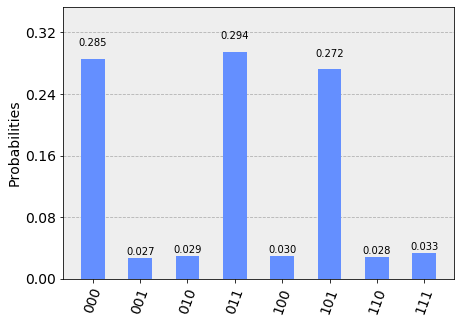

In [6]:
plot_histogram(result['measurement'])

We have seen that the simulator can find the solutions to the example problem. We would like to see what happens if we use the real quantum devices that have noise and imperfect gates. 

However, due to the restriction on the length of strings that can be sent over the network to the real devices (there are more than sixty thousands characters of QASM of the circuit), at the moment the above circuit cannot be run on real device backends. We can see the compiled QASM on real-device `ibmq_16_melbourne` backend as follows:

In [7]:
# Load our saved IBMQ accounts and get the ibmq_16_melbourne backend
from qiskit import IBMQ
IBMQ.load_accounts()

backend = IBMQ.get_backend('ibmq_16_melbourne')

In [8]:
from qiskit.compiler import transpile

# transpile the circuit for ibmq_16_melbourne
grover_compiled = transpile(result['circuit'], backend=backend, optimization_level=3)

print('gates = ', grover_compiled.count_ops())
print('depth = ', grover_compiled.depth())

gates =  {'u3': 966, 'u2': 1192, 'cx': 479, 'u1': 5, 'barrier': 2, 'measure': 3}
depth =  1107


The number of gates is in the order of thousands which is above the limits of decoherence time of the current near-term quantum computers. It is a challenge to design a quantum circuit for Grover search to solve satisfiability and other optimization problems.

## 4. Problems <a id='problems'></a>

1. Use Qiskit Aqua to solve the following 3SAT problem: $f(x_1, x_2, x_3) = (x_1 \vee x_2 \vee \neg x_3) \wedge (\neg x_1 \vee \neg x_2 \vee \neg x_3) \wedge (\neg x_1 \vee x_2 \vee x_3)$. Are the results what you expect?


## 5. References <a id='references'></a>

1. Giacomo Nannicini (2017), "An Introduction to Quantum Computing, Without the Physics", [arXiv:1708.03684 ](https://arxiv.org/abs/1708.03684)

In [9]:
import qiskit
qiskit.__qiskit_version__

{'qiskit': '0.10.4',
 'qiskit-terra': '0.8.2',
 'qiskit-ignis': '0.1.1',
 'qiskit-aer': '0.2.1',
 'qiskit-ibmq-provider': '0.2.2',
 'qiskit-aqua': '0.5.1'}